В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
#pip install mlxtend

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from process_bank_churn import preprocess_data, preprocess_new_data

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA


import time
#from sklearn.metrics import classification_report

Виконаємо маштабування даних, так як провівши декілька експерементів отримала гірші результати без маштабування

In [3]:
main_df = pd.read_csv('./bank-customer-churn-prediction-dlu/train.csv', index_col=0)

column_for_drop = ['Surname','CustomerId']
target = 'Exited'
data = preprocess_data(main_df, target, column_for_drop, scaler_numeric=True)
X_train = data['train_X']
train_targets = data['train_y']
X_val = data['val_X']
val_targets = data['val_y']

display(X_train)
display(train_targets)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.005452,0.034419,1.431840,-0.711819,-1.110115,0.515968,-0.979053,0.043440,0.0,0.0,1.0,1.0,0.0
1,0.796518,0.034419,0.354008,-0.711819,2.630269,0.515968,-0.979053,0.899369,1.0,0.0,0.0,1.0,0.0
2,-0.904212,-0.087489,1.431840,1.669468,0.760077,-1.938103,1.021395,1.289040,0.0,1.0,0.0,1.0,0.0
3,0.049856,1.741125,-1.442379,1.116976,-1.110115,0.515968,-0.979053,1.683999,0.0,1.0,0.0,0.0,1.0
4,-0.420265,0.156326,0.713285,0.625216,0.760077,0.515968,1.021395,-0.725591,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,-0.973348,-1.062750,1.072563,1.834373,-1.110115,0.515968,-0.979053,-0.591402,0.0,0.0,1.0,0.0,1.0
11996,-0.613844,-0.818935,-0.005269,1.739757,0.760077,0.515968,1.021395,-1.144856,0.0,1.0,0.0,0.0,1.0
11997,0.602939,-0.575119,-1.442379,1.252275,0.760077,0.515968,-0.979053,0.365707,0.0,1.0,0.0,1.0,0.0
11998,-0.862731,-0.818935,1.791118,1.368532,-1.110115,0.515968,1.021395,0.955116,1.0,0.0,0.0,0.0,1.0


id
9839     1.0
9680     0.0
7093     0.0
11293    1.0
820      0.0
        ... 
5191     0.0
13418    0.0
5390     0.0
860      0.0
7270     0.0
Name: Exited, Length: 12000, dtype: float64

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [18]:
def compute_auroc_and_build_roc(train_targets, train_probs, val_targets, val_probs, name=''):
  
  # Compute ROC curve
  fpr_train, tpr_train, trashold = roc_curve(train_targets, train_probs, pos_label=1.0)
  fpr_val, tpr_val, trashold = roc_curve(val_targets, val_probs, pos_label=1.0)

  # Compute AUROC
  roc_auc_train = auc(fpr_train, tpr_train)
  roc_auc_val = auc(fpr_val, tpr_val)
  print(f'AUROC for Train: {roc_auc_train:.2f}')
  print(f'AUROC for Val: {roc_auc_val:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC curve Train (area = {roc_auc_train:.2f})')
  plt.plot(fpr_val, tpr_val, color='Blue', lw=2, label=f'ROC curve Val (area = {roc_auc_val:.2f})')

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name} model')
  plt.legend(loc="lower right")
  plt.show()

  return roc_auc_train, roc_auc_val


AUROC for Train: 0.96
AUROC for Val: 0.87


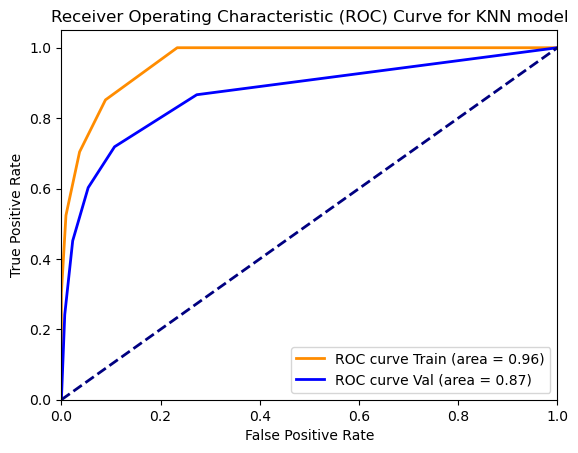

In [19]:
knn = KNeighborsClassifier()
knn.fit(X_train, train_targets)

train_pred_knn = knn.predict_proba(X_train)[:,1]
val_pred_knn = knn.predict_proba(X_val)[:,1]

train_roc_auc_knn, val_roc_auc_knn = compute_auroc_and_build_roc(
    train_targets, train_pred_knn, val_targets, val_pred_knn, 'KNN'
    )

Модель показує вищу точність на тренувальному наборі порівняно з валідаційним, що вказує на перенавчання. Модель добре працює на тренувальних даних, але не так чітко опрацьовує нові дані - High Variance

спробую звести до двовимірного масиву і звізуалізувати дані 

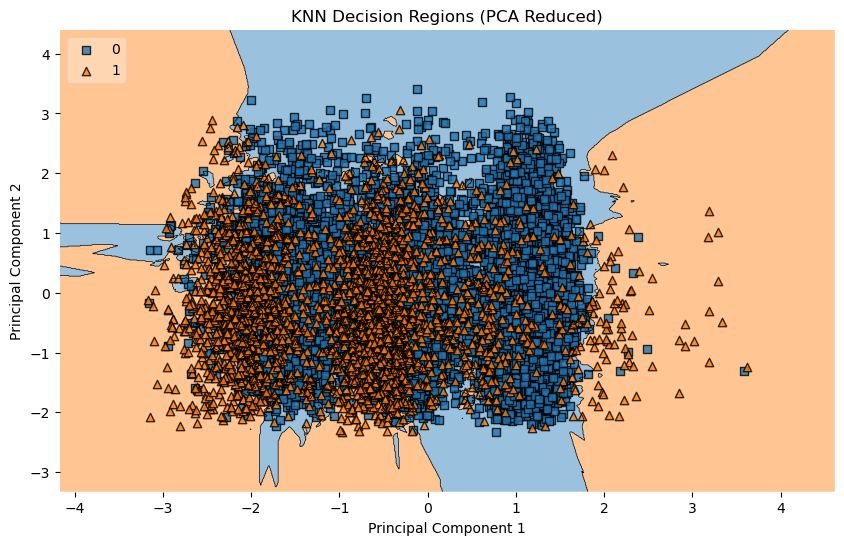

In [23]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# Налаштування моделі KNN
knn_pca = KNeighborsClassifier()
knn_pca.fit(X_train_pca, train_targets)

# Передбачення ймовірностей для тренувальних та валідаційних даних
train_pred_knn_pca = knn_pca.predict_proba(X_train_pca)[:, 1]
val_pred_knn_pca = knn_pca.predict_proba(X_val_pca)[:, 1]

# Візуалізація областей рішень для KNN після PCA
plt.figure(figsize=(10, 6))
plot_decision_regions(X_train_pca, train_targets.values.astype(np.int_), clf=knn_pca, legend=2)
plt.title("KNN Decision Regions (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

Найкраще значення n_neighbors: 21
AUROC for Train: 0.94
AUROC for Val: 0.91


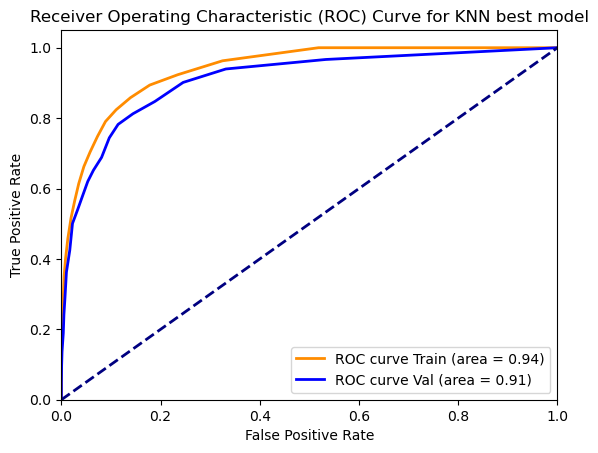

In [26]:
knn_adj = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1, 30)}

grid_search = GridSearchCV(knn_adj, param_grid, cv=5,)
grid_search.fit(X_train, train_targets)

# Отримуємо найкращі параметри та модель
best_params_knn_adj = grid_search.best_params_
knn_best = grid_search.best_estimator_

print('Найкраще значення n_neighbors:', best_params_knn_adj['n_neighbors'])

# Оцінка якості передбачень на тренувальній і валідаційній вибірках
train_pred_knn_adj = knn_best.predict_proba(X_train)[:, 1]
val_pred_knn_adj = knn_best.predict_proba(X_val)[:, 1]

train_roc_auc_knn_adj, val_roc_auc_knn_adj = compute_auroc_and_build_roc(
    train_targets, train_pred_knn_adj, val_targets, val_pred_knn_adj, 'KNN best'
    )

Можна вважати, що нова модель краща, так як має вищу AUROC на валідаційній вибірці порівняно з попереднюю моделю, можливо необхідно спробувати ще додати параметрів для покращення моделі.

In [28]:
# Порівняння з попередніми результатами
train_roc_auc_decision_tree = 0.94
val_roc_auc_decision_tree = 0.92

# Порівняння моделей на тренувальних даних
print("Порівняння моделей на тренувальних даних:")
print(f"Decision Tree Train ROC AUC: {train_roc_auc_decision_tree:.2f}")
print(f"Попередній kNN Train ROC AUC: {train_roc_auc_knn:.2f}")
print(f"Налаштований kNN Train ROC AUC: {train_roc_auc_knn_adj:.2f}")

# Порівняння моделей на валідаційних даних
print("\nПорівняння моделей на валідаційних даних:")
print(f"Decision Tree Validation ROC AUC: {val_roc_auc_decision_tree:.2f}")
print(f"Попередній kNN Validation ROC AUC: {val_roc_auc_knn:.2f}")
print(f"Налаштований kNN Validation ROC AUC: {val_roc_auc_knn_adj:.2f}")


Порівняння моделей на тренувальних даних:
Decision Tree Train ROC AUC: 0.94
Попередній kNN Train ROC AUC: 0.96
Налаштований kNN Train ROC AUC: 0.94

Порівняння моделей на валідаційних даних:
Decision Tree Validation ROC AUC: 0.92
Попередній kNN Validation ROC AUC: 0.87
Налаштований kNN Validation ROC AUC: 0.91


На даному етапі маємо найкращі результати моделі дерев прийняття рішення налаштованої в попередньому завданні, по класифікації з параметрами за замовченням маємо перенавчену модель і отримали непогані результати після налаштувань параметрів 

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_seed`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

Час пошуку оптимальних гіперпараметрів: 3.5641019344329834
Найкращі значення параметрів: {'max_depth': 5, 'min_samples_leaf': 8}
AUROC for Train: 0.93
AUROC for Val: 0.91


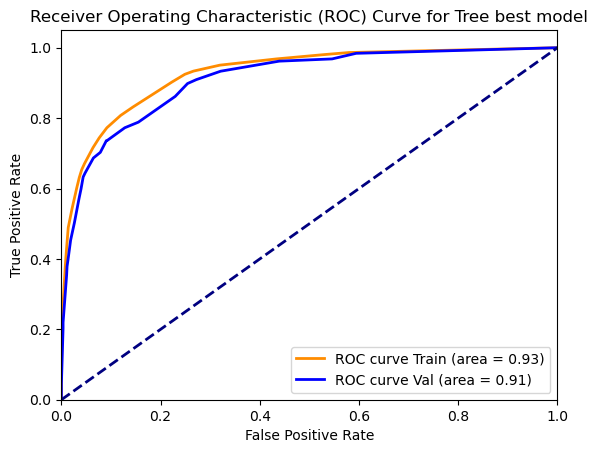

In [32]:
# Налаштування параметрів для GridSearchCV
param_model = {
    'max_depth': range(1, 21, 2),
    #'max_leaf_nodes': range(2, 11)
    'min_samples_leaf': range(2, 11)
}

dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(dt, param_model, cv=3, scoring='roc_auc')
start_time = time.time()
grid_search.fit(X_train, train_targets)
end_time = time.time()

search_time = end_time - start_time

best_param_dt = grid_search.best_params_
best_dt = grid_search.best_estimator_

print("Час пошуку оптимальних гіперпараметрів:", search_time)
print("Найкращі значення параметрів:", best_param_dt)

train_pred_df_best = best_dt.predict_proba(X_train)[:, 1]
y_val_pred_dt_best = best_dt.predict_proba(X_val)[:, 1]

train_roc_auc_dt_best, val_roc_auc_dt_best= compute_auroc_and_build_roc(
    train_targets, train_pred_df_best, val_targets, y_val_pred_dt_best, 'Tree best'
    )


In [33]:
# Порівняння моделей на тренувальних даних
print("Порівняння моделей на тренувальних даних:")
print(f"Decision Tree Train ROC AUC: {train_roc_auc_decision_tree:.2f}")
print(f"Налаштований Decision Tree Train ROC AUC: {train_roc_auc_dt_best:.2f}")

# Порівняння моделей на валідаційних даних
print("\nПорівняння моделей на валідаційних даних:")
print(f"Decision Tree Validation ROC AUC: {val_roc_auc_decision_tree:.2f}")
print(f"Налаштований Decision Tree Validation ROC AUC: {val_roc_auc_dt_best:.2f}")

Порівняння моделей на тренувальних даних:
Decision Tree Train ROC AUC: 0.94
Налаштований Decision Tree Train ROC AUC: 0.93

Порівняння моделей на валідаційних даних:
Decision Tree Validation ROC AUC: 0.92
Налаштований Decision Tree Validation ROC AUC: 0.91


(Підібрала параметри? які використовувала в попередній моделі)
Модель не показала кращі результати ніж підібрані вручну, але справилась доволі добре, що оптимізує процес роботи в цілому, але для якіснішого навчання я б використовувала цей метод як орієнтирир вибору значень з якими можна експерементувати.

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

Час пошуку оптимальних гіперпараметрів: 0.45736193656921387
Найкращі значення параметрів (RandomizedSearchCV): {'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 16, 'criterion': 'entropy'}
AUROC for Train: 0.92
AUROC for Val: 0.90


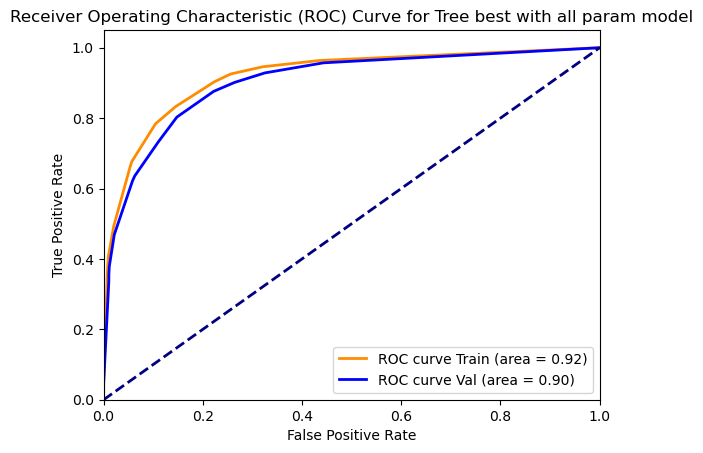

In [34]:
params_model_all = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

dt_all_param = DecisionTreeClassifier(random_state=42)

random_search = RandomizedSearchCV(
    dt_all_param, params_model_all, n_iter=40, cv=3, scoring='roc_auc', random_state=42
)

start_time = time.time()
random_search.fit(X_train, train_targets)
end_time = time.time()

search_time = end_time - start_time

# Отримуємо найкращі параметри та модель
best_params_dt_random = random_search.best_params_
best_dt_random = random_search.best_estimator_

print("Час пошуку оптимальних гіперпараметрів:", search_time)
print("Найкращі значення параметрів (RandomizedSearchCV):", best_params_dt_random)

train_pred_dt_random = best_dt_random.predict_proba(X_train)[:, 1]
val_pred_dt_random = best_dt_random.predict_proba(X_val)[:, 1]

train_roc_auc_dt_random, val_roc_auc_dt_random = compute_auroc_and_build_roc(
    train_targets, train_pred_dt_random, val_targets, val_pred_dt_random, 'Tree best with all param'
    )


In [36]:
# Порівняння моделей на тренувальних даних
print("Порівняння моделей на тренувальних даних:")
print(f"Decision Tree Train ROC AUC: {train_roc_auc_decision_tree:.2f}")
print(f"Налаштований Decision Tree Train ROC AUC: {train_roc_auc_dt_best:.2f}")
print(f"Налаштований з найкращими рандомнити параметрами Decision Tree Train ROC AUC: {train_roc_auc_dt_random:.2f}")

# Порівняння моделей на валідаційних даних
print("\nПорівняння моделей на валідаційних даних:")
print(f"Decision Tree Validation ROC AUC: {val_roc_auc_decision_tree:.2f}")
print(f"Налаштований Decision Tree Validation ROC AUC: {val_roc_auc_dt_best:.2f}")
print(f"Налаштований з найкращими рандомнити параметрами Decision Tree Train ROC AUC: {val_roc_auc_dt_random:.2f}")

Порівняння моделей на тренувальних даних:
Decision Tree Train ROC AUC: 0.94
Налаштований Decision Tree Train ROC AUC: 0.93
Налаштований з найкращими рандомнити параметрами Decision Tree Train ROC AUC: 0.92

Порівняння моделей на валідаційних даних:
Decision Tree Validation ROC AUC: 0.92
Налаштований Decision Tree Validation ROC AUC: 0.91
Налаштований з найкращими рандомнити параметрами Decision Tree Train ROC AUC: 0.90


Модель справилась гірше за попередню, висновки аналогічні до попередніх, добре використовувати для напрямку вибору параметрів


5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

пропускаю так як змагання вже завершені і жодна з моделей не показала кращого результату на тренувальних та валідаційних даних, хоча було б цікаво подивитись як би справилась на тестових